# Installations & Imports

In [ ]:
!pip install pyod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import GridSearchCV
from pyod.models.mad import MAD
from sklearn.model_selection import train_test_split

# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Merge data together

In [ ]:
# Merge datasets from team together

data1 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_1.csv")
# print(data1.shape)
# print(data1.columns)
data2 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_2.csv")
data2.drop(['Unnamed: 0.1'], axis=1, inplace=True)
# print(data2.shape)
# print(data2.columns)
data3 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/final_dataset_3.csv")
data3.drop(['Unnamed: 0.1'], axis=1, inplace=True)
# print(data3.shape)
# print(data3.columns)
data4 = pd.read_csv("/content/drive/Shareddrives/CS 229 Final Project/CS 229 Project/compiled_dataset.csv")
# print(data4.shape)
# print(data4.columns)
data = pd.concat([data1, data2, data3, data4], ignore_index=True)
print(data.shape)
print(data.columns)
data.drop(['Unnamed: 0'],  axis=1, inplace=True)
print(data.shape)
print(data.columns)

(160000, 20)
Index(['Unnamed: 0', 'start_date', 'FIRE_SIZE_CLASS', 'category', 'cause',
       'size', 'lat', 'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10',
       'v10', 't2m', 'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')
(160000, 19)
Index(['start_date', 'FIRE_SIZE_CLASS', 'category', 'cause', 'size', 'lat',
       'lon', 'buinfdr', 'ercnfdr', 'icnfdr', 'scnfdr', 'u10', 'v10', 't2m',
       'blh', 'cape', 'lai_hv', 'lai_lv', 'slt'],
      dtype='object')


# Data Clean-Up

In [ ]:
# Remove any duplicate rows
data.drop_duplicates(inplace=True)

# Remove any rows that have empty values
data.dropna(inplace=True)

# Keep all relevant features
data.drop(['FIRE_SIZE_CLASS', 'start_date'],  axis=1, inplace=True)

num_empty_vals = data[data.isna().any(axis=1)]
print("Num Empty Values: {}".format(num_empty_vals.shape[0]))
print("Shape of Clean Data: {}".format(data.shape))
#data.to_csv('final_data.csv', index = False) # visually make sure things look good
print("Feature Data Types:")
print((data.dtypes))

data_copy = copy.deepcopy(data)

Num Empty Values: 0
Shape of Clean Data: (98510, 17)
Feature Data Types:
category     object
cause        object
size        float64
lat         float64
lon         float64
buinfdr     float64
ercnfdr     float64
icnfdr      float64
scnfdr      float64
u10         float64
v10         float64
t2m         float64
blh         float64
cape        float64
lai_hv      float64
lai_lv      float64
slt         float64
dtype: object


# Remove Outliers from Data

In [ ]:
# Set threshold to 4
mad = MAD(threshold = 4)
total_reshaped = data_copy["size"].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(total_reshaped).labels_
print(f'Number of outliers: {labels.sum()}')
filter = data_copy[labels == 0].copy()
data_copy = filter
print("Shape of Clean Data Without Outliers: {}".format(data_copy.shape))

Number of outliers: 16524
Shape of Clean Data Without Outliers: (81986, 17)


# Gradient Boosted Decision Tree (Baseline)

In [ ]:
# Entire dataset (comment in if running entire dataset)
# Define input features and labels
# target_name = "size"
# y = data[target_name] # vector of labels [size of the fire in acres]
# data.drop(columns=[target_name], inplace=True) # input features

# # Define input features and labels
# X = data
# y = y
# print(X.shape)
# print(y.shape)

##################################################

# Transformed dataset (comment in if running transformed dataset)
# Define input features and labels
target_name = "size"
y = data_copy[target_name] # vector of labels [size of the fire in acres]
data_copy.drop(columns=[target_name], inplace=True) # input features

X = data_copy
print(X.shape)
print(y.shape)

###################################################

# Pull Categorical Features
categorical_columns_selector = make_column_selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# Create a pipeline that will use ordinal encoding for the categorical features
# and let the rest of the numerical data to passthrough
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Model - Gradient Boosting with Native Categorical Support
hist_grad_boost = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=42,
        categorical_features=categorical_columns
    ),
).set_output(transform="pandas")

(81986, 16)
(81986,)


# Gradient Boosted Decision Tree Prediction Visualization

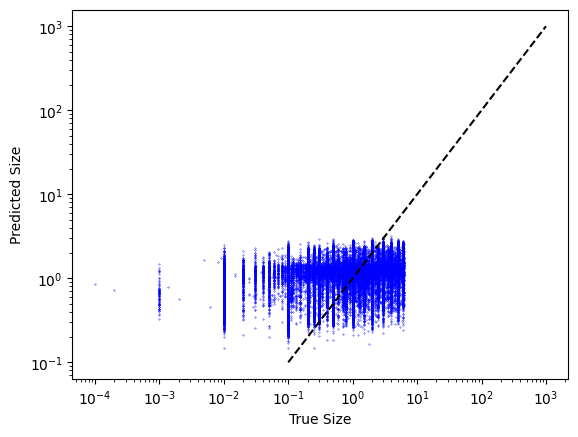

In [ ]:
# cross-validated estimates for each input data point
# generated from training K different models
# in cross-validation method

n_cv_folds = 5
y_pred = cross_val_predict(hist_grad_boost, X, y, cv=n_cv_folds)
#print(y_pred.shape)

plt.scatter(y, y_pred, s=0.3, marker='.', c='b')
plt.xlabel('True Size')
plt.ylabel('Predicted Size')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
#plt.show()

# Gradient Boosted Decision Tree Alternative Prediction Visualization

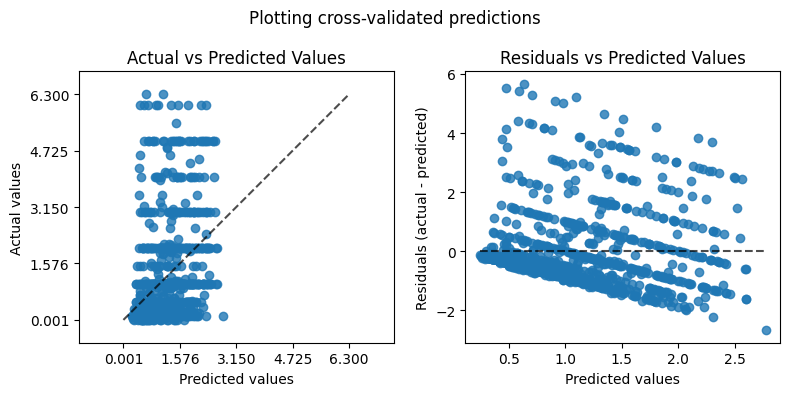

In [ ]:
n_cv_folds = 5
y_pred = cross_val_predict(hist_grad_boost, X, y, cv=n_cv_folds)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

PredictionErrorDisplay.from_predictions(
    y,
    y_pred = y_pred,
    kind="actual_vs_predicted",
    #subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs Predicted Values")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred = y_pred,
    kind="residual_vs_predicted",
    #subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
#plt.show()

# Error Visualization Using Cross-Validation

fit_time: 1.7379241466522217
score_time: 0.1424288272857666
test_neg_mean_absolute_error: 0.9245566247776498
train_neg_mean_absolute_error: 0.899518157722284
test_neg_mean_absolute_percentage_error: 5.921063157314055
train_neg_mean_absolute_percentage_error: 5.747911653354588


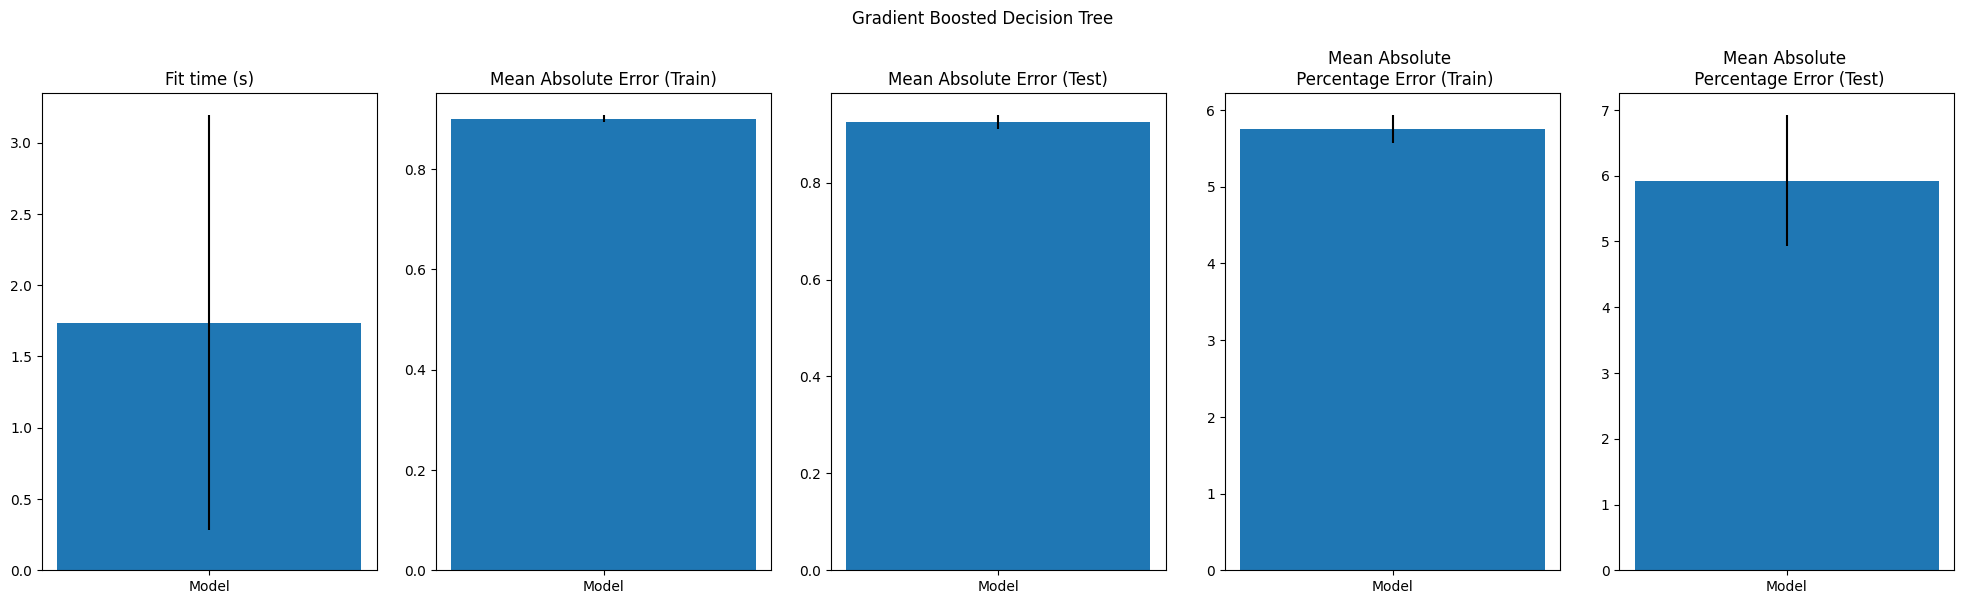

In [ ]:
# Cross-Validation
scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]
n_cv_folds = 5
model_result = cross_validate(hist_grad_boost, X, y, cv=n_cv_folds, scoring=scoring, return_train_score=True)
#print(model_result.keys())

def plot_results(figure_title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

    plot_info = [
        ("fit_time", "Fit time (s)", axes[0], None),
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[1], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[2], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[3], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[4], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = model_result[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("Gradient Boosted Decision Tree")
#plt.show()

for key in model_result:
  item = model_result[key]

  cv_mean = np.mean(np.abs(item))
  #cv_std = np.std(item)
  print(f'{key}: {cv_mean}')

# Error Visualization Using Cross-Validation with Hyperparameter Tuning

Best hyperparameters for fold #1:
{'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__max_iter': 150}
Best hyperparameters for fold #2:
{'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_iter': 100}
Best hyperparameters for fold #3:
{'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_iter': 100}
Best hyperparameters for fold #4:
{'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_iter': 100}
Best hyperparameters for fold #5:
{'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_iter': 100}
test_neg_mean_absolute_error: 0.9249702181939558
train_neg_mean_absolute_error: 0.9008065427977148
test_neg_mean_absolute_percentage_error: 5.938394529097893
train_neg_mean_absolute_percentage_error: 5.762146086377076


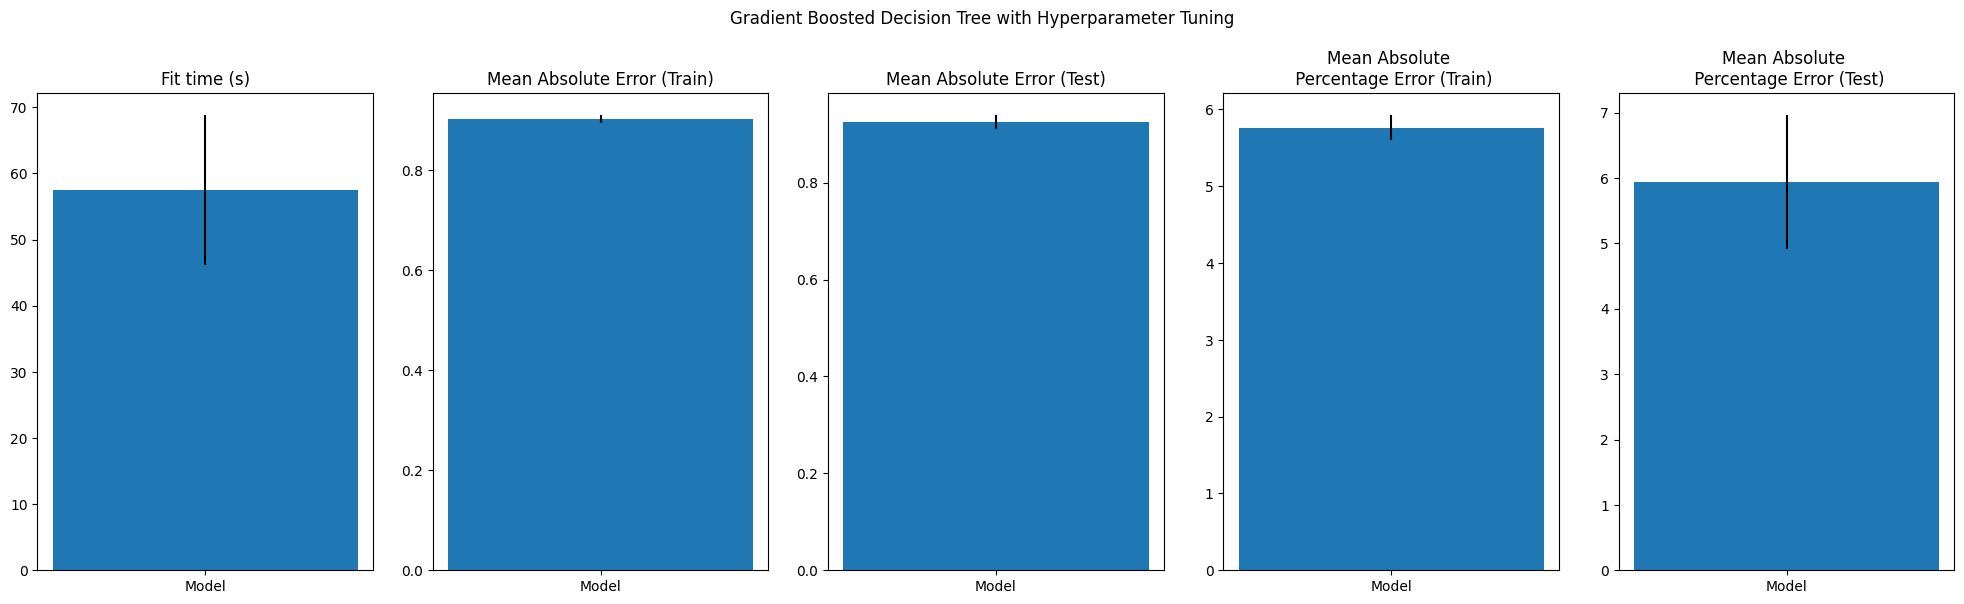

In [ ]:
# for parameter in hist_grad_boost.get_params():
#     print(parameter)

param_grid = {
    "histgradientboostingregressor__learning_rate": (0.05, 0.1, 0.5),
    "histgradientboostingregressor__max_iter": (100, 110, 150),
}

scoring_param = "neg_mean_absolute_error"
scoring_model = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]

model_grid_search = GridSearchCV(hist_grad_boost, param_grid=param_grid, scoring=scoring_param, n_jobs=2, cv=4)
model_grid_search.fit(X, y)
cv_results = cross_validate(
    model_grid_search, X, y, cv=5, n_jobs=2, return_train_score=True, return_estimator=True, scoring=scoring_model
)

def plot_results(figure_title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})

    plot_info = [
        ("fit_time", "Fit time (s)", axes[0], None),
        ("train_neg_mean_absolute_error", "Mean Absolute Error (Train)", axes[1], None),
        ("test_neg_mean_absolute_error", "Mean Absolute Error (Test)", axes[2], None),
        ("train_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Train)", axes[3], None),
        ("test_neg_mean_absolute_percentage_error", "Mean Absolute \n Percentage Error (Test)", axes[4], None)
    ]

    x, width = np.arange(1), 0.3
    for key, title, ax, y_limit in plot_info:
        item = cv_results[key]

        cv_mean = np.mean(np.abs(item))
        cv_std = np.std(item)

        ax.bar(
            x=x,
            height=cv_mean,
            width=width,
            yerr=cv_std,
            color="C0",
        )
        ax.set(
            title=title,
            xticks=x,
            xticklabels=["Model"],
            ylim=y_limit,
        )

    # Adjust layout and spacing
    plt.tight_layout(pad=2.0)
    fig.suptitle(figure_title, y=1.02)  # Adjust the vertical position of the title

plot_results("Gradient Boosted Decision Tree with Hyperparameter Tuning")

for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

for key in ["test_neg_mean_absolute_error", "train_neg_mean_absolute_error",
            "test_neg_mean_absolute_percentage_error", "train_neg_mean_absolute_percentage_error"]:

  item = cv_results[key]

  cv_mean = np.mean(np.abs(item))
  #cv_std = np.std(item)
  print(f'{key}: {cv_mean}')

# Feature Analysis

In [ ]:
# We ran this twice, once for the full dataset and once for the transformed dataset

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
)

extra_trees_regress = make_pipeline(
    ordinal_encoder, ExtraTreesRegressor(random_state=42, criterion='absolute_error')
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

extra_trees_regress.fit(X_train, y_train)

transformed_feature_names = (
    ordinal_encoder.get_feature_names_out(input_features=X.columns.tolist())
)

model = extra_trees_regress.named_steps['extratreesregressor']

# Access the feature importances
feature_importances = pd.Series(model.feature_importances_, index=transformed_feature_names)

# Plot the feature importances
ax = feature_importances.nlargest(20).plot(kind='barh')
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')